In [ ]:
import json
import dask.dataframe as dd
import numpy as np
from tqdm import tqdm
from astrapy import DataAPIClient

# Read and Create Bronze Table

In [5]:
raw_df = dd.read_csv("data/bronze_yellow_tripdata.csv", assume_missing=True)

In [6]:
def connect_to_database(config_path):
    with open(config_path) as f:
        config = json.load(f)
        
    client = DataAPIClient(config["ASTRA_DB_TOKEN"])
    db = client.get_database_by_api_endpoint(config["ASTRA_DB_API_ENDPOINT"])
    return db,client

In [7]:
db,_ = connect_to_database('config.json')

In [8]:

def load_data_to_cassandra(df,db,collection_name, step=100):
    try:
        if collection_name not in db.list_collection_names():
            print(f"\nCollection {collection_name} does not exist. Creating {collection_name}")
            db.create_collection(collection_name)
        collection = db.get_collection(collection_name)
        docs = df.to_dict(orient="records")
    except Exception as e:
         print(f"\nAn error occurred while connecting to collections : {e}")
         return 
    
    pbar = tqdm(total=len(df),desc="Data Uploaded ")
    try:
        records = []
        for i,doc in enumerate(docs):
            records.append(doc)
            if((i+1)%100==0):
                collection.insert_many(records)
                pbar.update(len(records))
                records.clear()
            elif((i+1)==len(df)):
                collection.insert_many(records)
                pbar.update(len(records))
                records.clear()
        print(f"\nData loaded into Cassandra {collection_name} Table")
        print(f"Total Columns: {len(df.columns)} Total Rows: {len(df)}")
        
    except Exception as e:
         print(f"\nAn error occurred while uploading data row {i} to {collection_name}: {e}")
    finally:
        pbar.close()
                

In [ ]:
load_data_to_cassandra(raw_df.compute(),db,"bronze_trips")

# Clean and Create Silver Table

In [9]:
def clean_data(df, filepath="data/silver_cleaned_tripdata.csv"):
    try:
        clean_df = df.dropna()
        clean_df = clean_df[(clean_df['passenger_count'] > 0) &
                            (clean_df['trip_distance'] > 0) &
                            (clean_df['fare_amount'] > 0)]

        clean_df = clean_df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
                            'trip_distance', 'fare_amount','extra', 'mta_tax', 'tip_amount','tolls_amount','total_amount','improvement_surcharge', 'payment_type',
                            'PULocationID', 'DOLocationID','congestion_surcharge','airport_fee']]
        
        for col in ['tpep_pickup_datetime', 'tpep_dropoff_datetime']:
            if col in clean_df.columns:
                clean_df[col] = dd.to_datetime(clean_df[col], utc=True)
        
        clean_df.to_csv(filepath, index=False, single_file=True)
        print("\nData Cleaned and Saved")
        return clean_df
    except Exception as e:
        print(f"\nAn error occurred while cleaning data : {e}")

In [10]:
clean_df = clean_data(raw_df)


Data Cleaned and Saved


In [ ]:
load_data_to_cassandra(clean_df.compute(),db,"silver_trips", step=100)

In [ ]:
len(clean_df),len(clean_df.columns)

# Create Aggregate Data Sets 

In [99]:
df = clean_df.copy()
import matplotlib.pyplot as plt

In [100]:
summary = df.describe().compute()
summary.drop(['DOLocationID','PULocationID','payment_type'],axis=1,inplace=True)

In [111]:
mean

['passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'improvement_surcharge',
 'congestion_surcharge',
 'airport_fee',
 'statistics']

In [114]:
np.array(summary.loc['mean'].compute())

array([[1, 4.523777701964116, 22.17130873721515, 1.2420180049712102,
        0.4949317328914481, 3.6214969330279123, 0.8096179687663184,
        31.154362202092923, 0, 2.227036002979941, 0.17412290168283123,
        'mean']], dtype=object)

In [131]:
mean.shape

(10,)

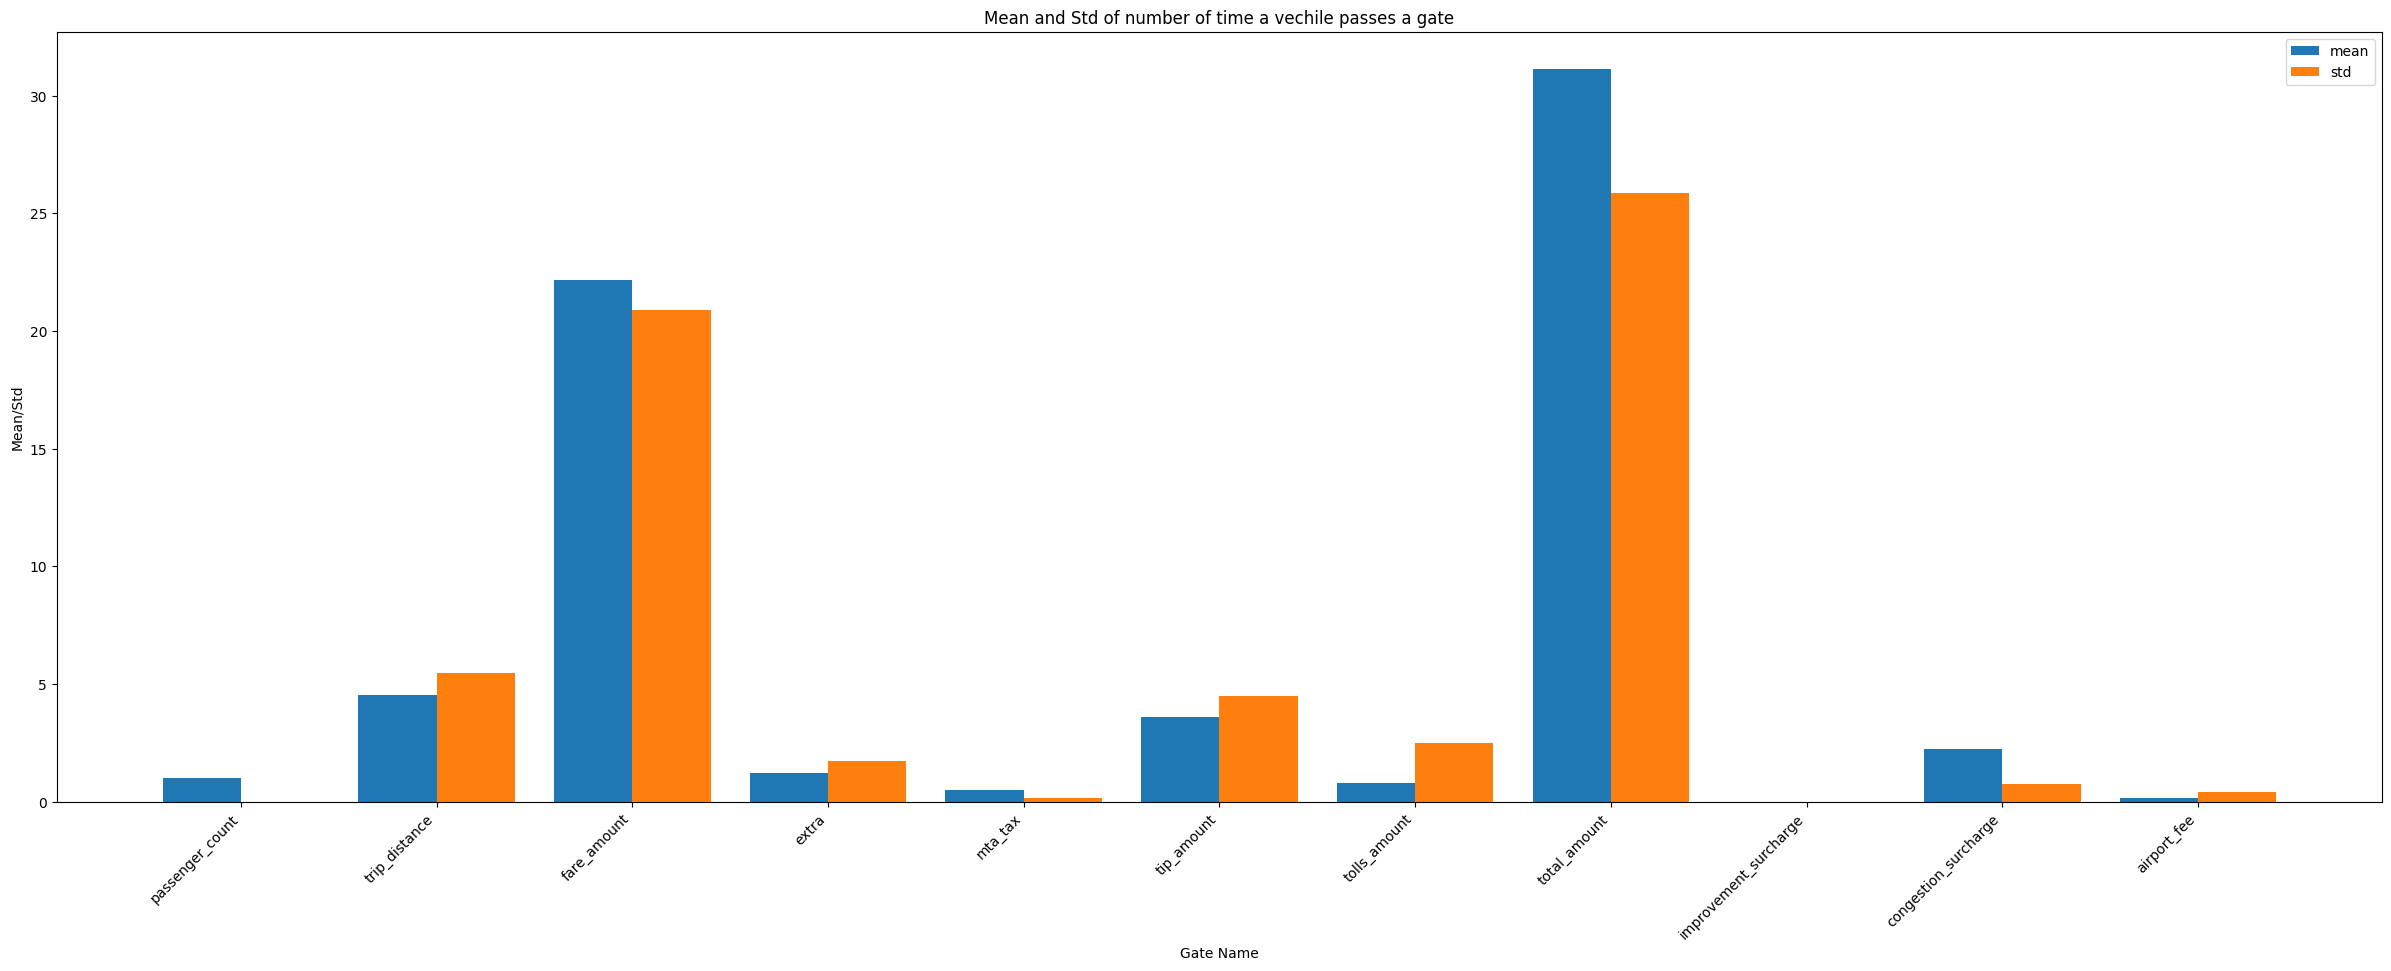

In [132]:
X = summary.columns
mean = np.array(summary.loc['mean'])[0]
std = np.array(summary.loc['std'])[0]
  
X_axis = np.arange(len(X)) 
fig = plt.figure(figsize=(30,10))
plt.bar(X_axis - 0.2, mean, 0.4, label = 'mean') 
plt.bar(X_axis + 0.2, std, 0.4, label = 'std') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Gate Name") 
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean/Std") 
plt.title("Mean and Std of number of time a vechile passes a gate") 
plt.legend() 
plt.show() 

In [149]:
df = read_data_from_cassandra(database,"silver_trips")


Reading data from silver_trips collection...
Loaded 143627 rows from silver_trips into Dask DataFrame


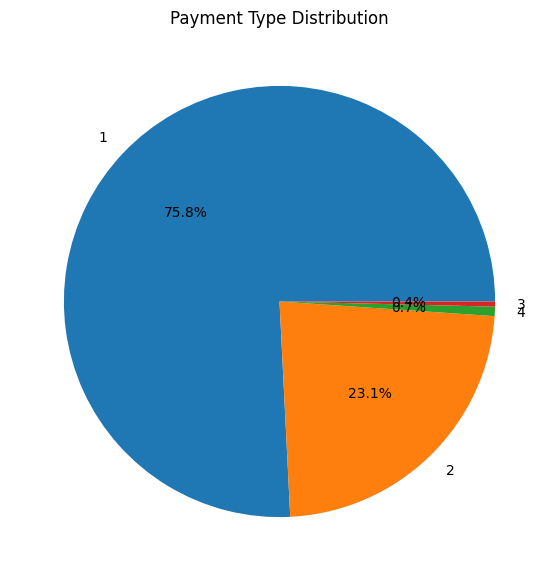

In [150]:
payment_type_counts =  df['payment_type'].compute().value_counts()

fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(payment_type_counts, labels=payment_type_counts.index, autopct='%1.1f%%')

ax.set_title('Payment Type Distribution')

plt.show()

In [85]:
import dask.dataframe as dd
import dask.bag as db

def read_data_from_cassandra(db_client, collection_name,npartitions=100):
    """
    Reads data from a Cassandra collection into a Dask DataFrame.

    Parameters:
    - db_client: The Astra DB client object.
    - collection_name: Name of the Cassandra collection/table.

    Returns:
    - Dask DataFrame containing the collection data.
    """
    try:
        if collection_name not in db_client.list_collection_names():
            print(f"\nCollection {collection_name} does not exist.")
            return None
        
        collection = db_client.get_collection(collection_name)
        print(f"\nReading data from {collection_name} collection...")

        # Fetch all documents as a Python list
        docs = list(collection.find({}))

        if not docs:
            print(f"\nNo documents found in {collection_name}.")
            return None
        
        # Use Dask Bag to parallelize the list
        bag = db.from_sequence(docs, npartitions=npartitions)  # You can tune partitions
        # Convert Dask Bag to Dask DataFrame
        df = bag.to_dataframe()

        print(f"Loaded {len(docs)} rows from {collection_name} into Dask DataFrame")
        return df
    
    except Exception as e:
        print(f"\nAn error occurred while reading from {collection_name}: {e}")
        return None


In [87]:
import dask.bag as db

In [124]:
database,_ = connect_to_database('config.json')
summary = read_data_from_cassandra(database,"gold_distribution_data")


Reading data from gold_distribution_data collection...
Loaded 8 rows from gold_distribution_data into Dask DataFrame


In [125]:
summary.index = summary.statistics

In [126]:
summary = summary.drop(['_id','statistics'], axis=1)

In [127]:
summary.compute()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,improvement_surcharge,congestion_surcharge,airport_fee
statistics,,,,,,,,,,,
max,6,114.270000,496.500000,11.250000,53.160000,211.500000,49.850000,505.800000,1,2.500000,1.250000
75%,2,5.050000,26.100000,2.500000,0.500000,4.540000,0.000000,34.400000,1,2.500000,0.000000
25%,1,1.220000,9.300000,0.000000,0.500000,0.000000,0.000000,15.120000,1,2.500000,0.000000
mean,1,4.523778,22.171309,1.242018,0.494932,3.621497,0.809618,31.154362,0,2.227036,0.174123
50%,1,2.200000,14.200000,1.000000,0.500000,2.580000,0.000000,20.790000,1,2.500000,0.000000
std,0,5.475633,20.897678,1.720129,0.148648,4.505911,2.498189,25.860540,0,0.779683,0.432823
count,143627,143627.000000,143627.000000,143627.000000,143627.000000,143627.000000,143627.000000,143627.000000,143627,143627.000000,143627.000000
min,1,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,1.010000,0,0.000000,0.000000


In [72]:
import pandas as pd

In [74]:
df = pd.DataFrame(summary.drop(["_id"],axis=1).compute())

In [79]:
df.index = df['statistics']

In [80]:
df

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,improvement_surcharge,congestion_surcharge,airport_fee,statistics
statistics,,,,,,,,,,,,
0,6.000000,114.270000,496.500000,11.250000,53.160000,211.500000,49.850000,505.800000,1.000000,2.500000,1.250000,0
1,2.000000,5.050000,26.100000,2.500000,0.500000,4.540000,0.000000,34.400000,1.000000,2.500000,0.000000,1
2,1.000000,1.220000,9.300000,0.000000,0.500000,0.000000,0.000000,15.120000,1.000000,2.500000,0.000000,2
3,1.539474,4.523778,22.171309,1.242018,0.494932,3.621497,0.809618,31.154362,0.997817,2.227036,0.174123,3
4,1.000000,2.200000,14.200000,1.000000,0.500000,2.580000,0.000000,20.790000,1.000000,2.500000,0.000000,4
5,0.991381,5.475633,20.897678,1.720129,0.148648,4.505911,2.498189,25.860540,0.039221,0.779683,0.432823,5
6,143627.000000,143627.000000,143627.000000,143627.000000,143627.000000,143627.000000,143627.000000,143627.000000,143627.000000,143627.000000,143627.000000,6
7,1.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,1.010000,0.000000,0.000000,0.000000,7


In [ ]:
load_data_to_cassandra(summary,db,"gold_distribution_data", step=100)

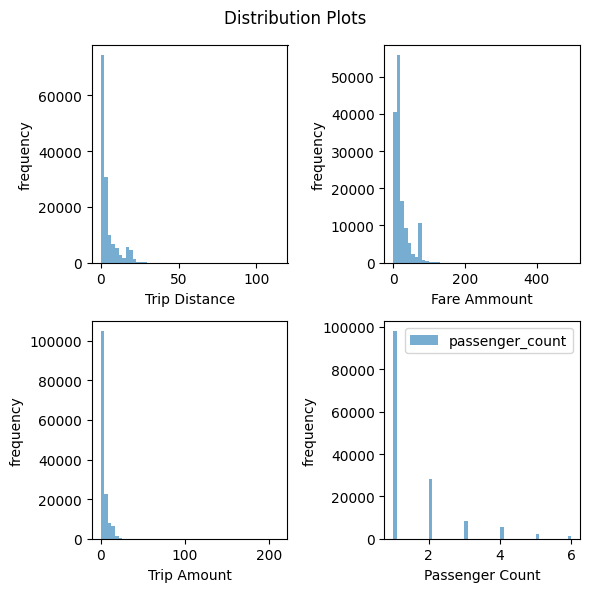

In [15]:
columns_to_plot = ['trip_distance', 'fare_amount', 'tip_amount','passenger_count']
names = ["Trip Distance","Fare Ammount", "Trip Amount","Passenger Count"]
fig,ax =  plt.subplots(2,2,figsize=(6,6))
axs = ax.flatten()
for i,col in enumerate(columns_to_plot):
    axs[i].hist(df[col], bins=50, alpha=0.6, label=col)
    axs[i].set_xlabel(names[i])
    axs[i].set_ylabel("frequency")

plt.suptitle('Distribution Plots')
plt.legend()
plt.tight_layout()

**Note:** None of the distribtion plots are normal, so cann't use statistical models for predicting or forecasting 

# Hourly Trip count

In [16]:
df["tpep_pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
daily_trips = df.groupby('tpep_pickup_hour').size().compute().reset_index(name='trip_count')
daily_trips.to_csv("data/gold_hourly_trip_count.csv", index=False)

In [ ]:
load_data_to_cassandra(daily_trips,db,"gold_hourly_trips", step=100)

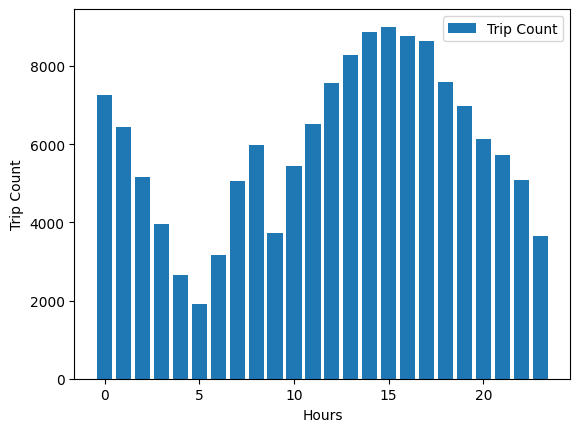

In [17]:
plt.bar(daily_trips['tpep_pickup_hour'].compute(), daily_trips['trip_count'].compute(),label="Trip Count")
plt.legend()
plt.xlabel("Hours")
plt.ylabel("Trip Count")
plt.show() 

In [ ]:
clean_df.head()

In [18]:
import seaborn as sns

In [27]:
columns_to_analyze = [
    "passenger_count", "trip_distance", "fare_amount", "extra", "mta_tax", 
    "tip_amount", "tolls_amount", "total_amount", "improvement_surcharge", 
    "congestion_surcharge", "airport_fee"
]

correlation_matrix = df[columns_to_analyze].compute().corr()

In [24]:
correlation_matrix['columns'] = correlation_matrix.index

In [ ]:
load_data_to_cassandra(correlation_matrix,db,"gold_corelation_data", step=100)

In [28]:
correlation_matrix

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,improvement_surcharge,congestion_surcharge,airport_fee
passenger_count,1.000000,0.044931,0.055800,-0.025862,-0.018180,0.019604,0.049259,0.053033,0.003506,0.018376,-0.000634
trip_distance,0.044931,1.000000,0.951917,0.128964,-0.070528,0.594046,0.636583,0.945013,0.013311,-0.345461,0.673778
fare_amount,0.055800,0.951917,1.000000,0.100659,-0.108531,0.594591,0.648429,0.982356,0.013190,-0.356746,0.613717
extra,-0.025862,0.128964,0.100659,1.000000,0.022182,0.141738,0.176326,0.165660,0.015279,-0.061514,0.306537
mta_tax,-0.018180,-0.070528,-0.108531,0.022182,1.000000,-0.055743,-0.152570,-0.103336,-0.074436,0.088012,0.000406
tip_amount,0.019604,0.594046,0.594591,0.141738,-0.055743,1.000000,0.449198,0.711013,0.011802,-0.155972,0.444486
tolls_amount,0.049259,0.636583,0.648429,0.176326,-0.152570,0.449198,1.000000,0.712385,0.010717,-0.175799,0.408872
total_amount,0.053033,0.945013,0.982356,0.165660,-0.103336,0.711013,0.712385,1.000000,0.015547,-0.319895,0.636716
improvement_surcharge,0.003506,0.013311,0.013190,0.015279,-0.074436,0.011802,0.010717,0.015547,1.000000,-0.001617,0.011271
congestion_surcharge,0.018376,-0.345461,-0.356746,-0.061514,0.088012,-0.155972,-0.175799,-0.319895,-0.001617,1.000000,-0.489911


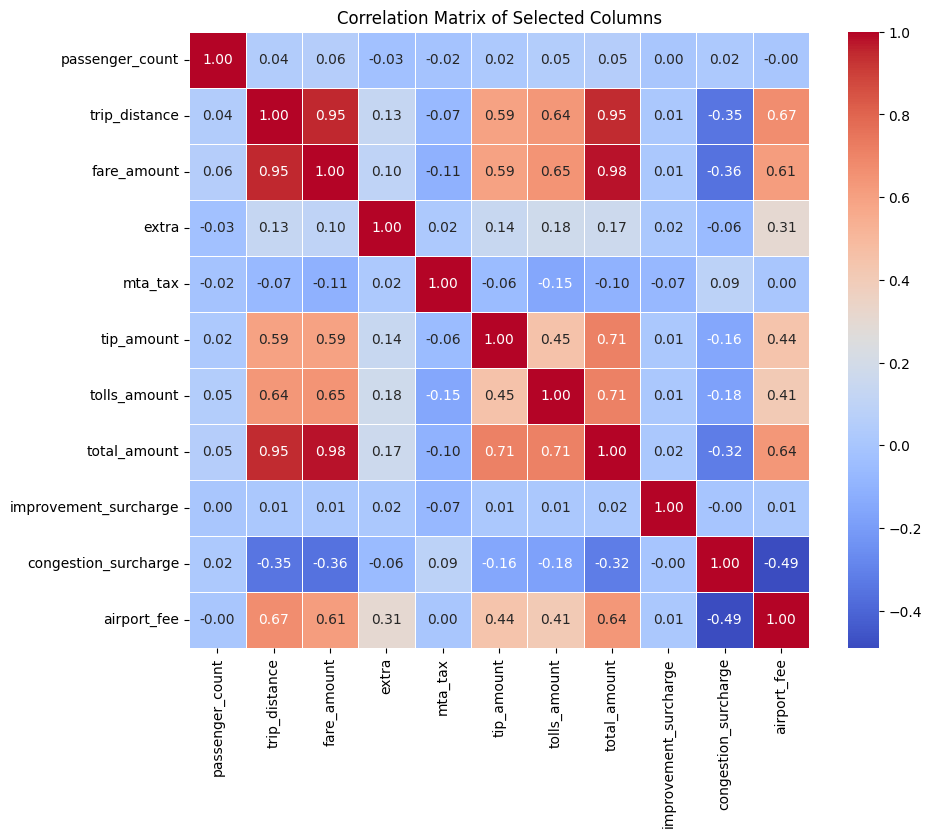

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)

plt.title('Correlation Matrix of Selected Columns')
plt.show()

**Note** Corelation is only good between trip distance and fare ammount. We also have corelation between total amount and fair ammount but that is obvious as total amount is fare amount + extra 

# ML Model for fare calculations

In [30]:
df_new = df.copy().compute()

In [31]:
df_new['tpep_pickup_hour'] = df_new["tpep_pickup_datetime"].dt.hour
df_new['tpep_dropoff_hour'] = df_new["tpep_dropoff_datetime"].dt.hour

In [32]:
df_new.drop(["tpep_pickup_datetime","tpep_dropoff_datetime","extra", "mta_tax", "tip_amount","tolls_amount", "total_amount","improvement_surcharge","congestion_surcharge", "airport_fee"	],axis=1,inplace=True)

In [33]:
df_new.head()

,passenger_count,trip_distance,fare_amount,payment_type,PULocationID,DOLocationID,tpep_pickup_hour,tpep_dropoff_hour
0,1.0,0.97,9.3,2.0,161.0,141.0,0,0
1,1.0,1.10,7.9,1.0,43.0,237.0,0,1
2,1.0,2.51,14.9,1.0,48.0,238.0,0,0
4,1.0,1.43,11.4,1.0,107.0,79.0,0,0
5,1.0,1.84,12.8,1.0,161.0,137.0,0,1


In [35]:

df_new = dd.get_dummies(df_new, columns=['PULocationID', 'DOLocationID'], drop_first=True)

In [36]:
df_new.head()

,passenger_count,trip_distance,fare_amount,payment_type,tpep_pickup_hour,tpep_dropoff_hour,PULocationID_3.0,PULocationID_4.0,PULocationID_5.0,PULocationID_6.0,...,DOLocationID_256.0,DOLocationID_257.0,DOLocationID_258.0,DOLocationID_259.0,DOLocationID_260.0,DOLocationID_261.0,DOLocationID_262.0,DOLocationID_263.0,DOLocationID_264.0,DOLocationID_265.0
0,1.0,0.97,9.3,2.0,0,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.0,1.10,7.9,1.0,0,1,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.0,2.51,14.9,1.0,0,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1.0,1.43,11.4,1.0,0,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,1.0,1.84,12.8,1.0,0,1,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [37]:
X = df_new.drop('fare_amount', axis=1)
y = df_new['fare_amount']

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Initialize models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Ridge Regression": Ridge(alpha=1.0)
}

In [41]:
# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results[name] = {
        'model': model,
        'r2': r2_score(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'predictions': y_pred
    }

In [ ]:

# Display results
metrics_df = dd.DataFrame.from_dict({k: [v['r2'], v['mse'], v['mae']] 
                                   for k, v in results.items()}, 
                                  orient='index',
                                  columns=['R2 Score', 'MSE', 'MAE'])

In [44]:
print(metrics_df.compute().sort_values('R2 Score', ascending=False))

                  R2 Score        MSE       MAE
Random Forest     0.935557  27.599763  1.935395
XGBoost           0.933676  28.405091  2.024037
Ridge Regression  0.927938  30.862504  2.439965


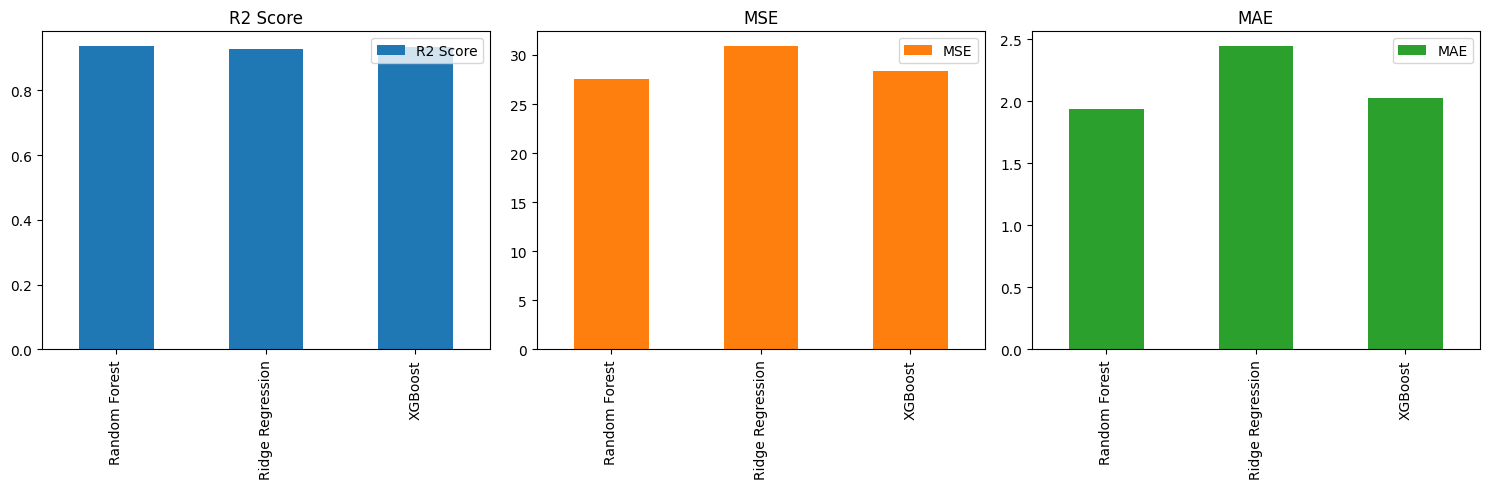

In [46]:
# 4. Metrics Comparison
metrics_df.compute().plot(kind='bar', subplots=True, layout=(1,3), figsize=(15,5))
plt.tight_layout()
plt.show()

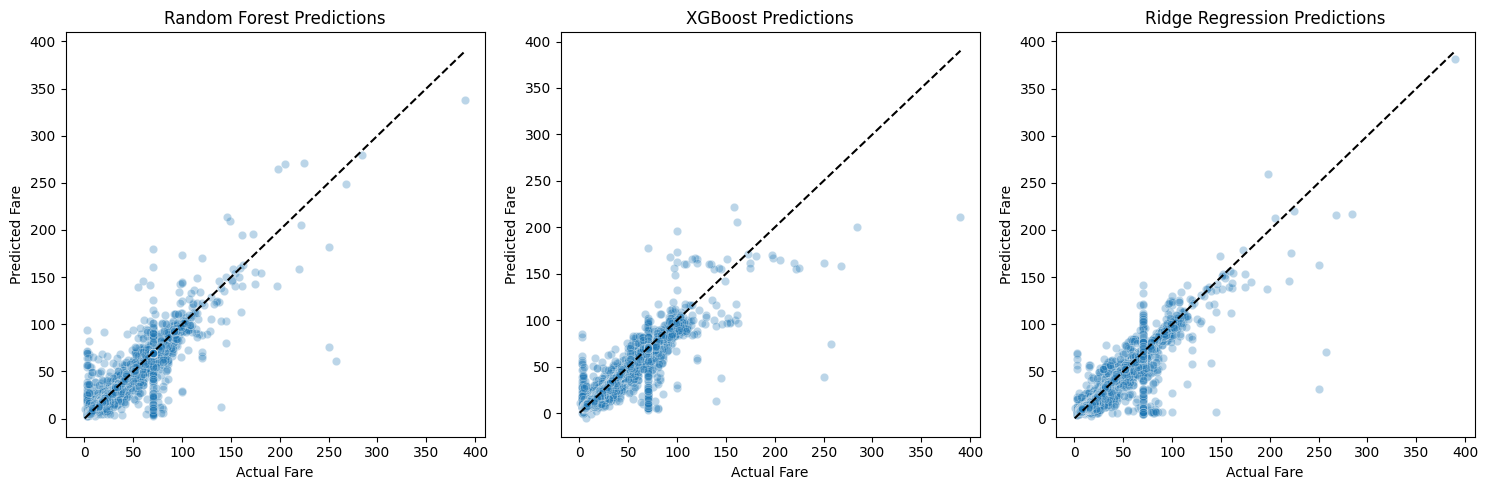

In [47]:
# 1. Actual vs Predicted Plot
plt.figure(figsize=(15, 5))
for i, (name, res) in enumerate(results.items(), 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=y_test, y=res['predictions'], alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.title(f'{name} Predictions')
    plt.xlabel('Actual Fare')
    plt.ylabel('Predicted Fare')
plt.tight_layout()
plt.show()

In [51]:
import pandas as pd

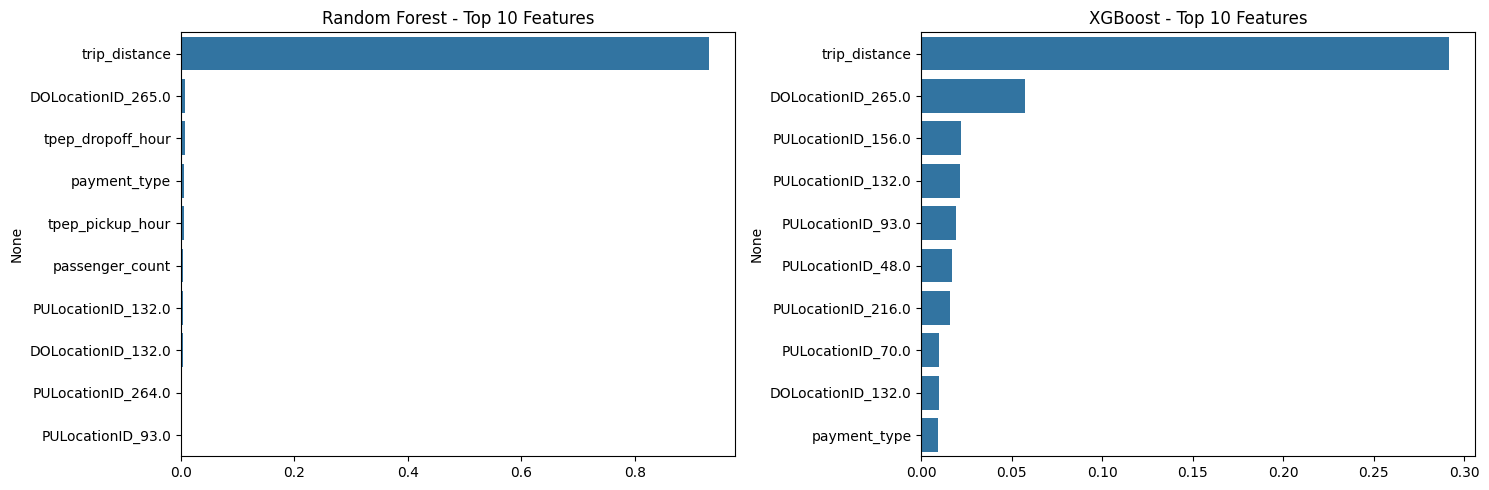

In [52]:
# 2. Feature Importance (for tree-based models)
plt.figure(figsize=(15, 5))
for i, (name, res) in enumerate(results.items(), 1):
    if hasattr(res['model'], 'feature_importances_'):
        plt.subplot(1, 2, i)
        importances = res['model'].feature_importances_
        top_features = pd.Series(importances, index=X.columns).sort_values(ascending=False)[:10]
        sns.barplot(x=top_features.values, y=top_features.index)
        plt.title(f'{name} - Top 10 Features')
plt.tight_layout()
plt.show()

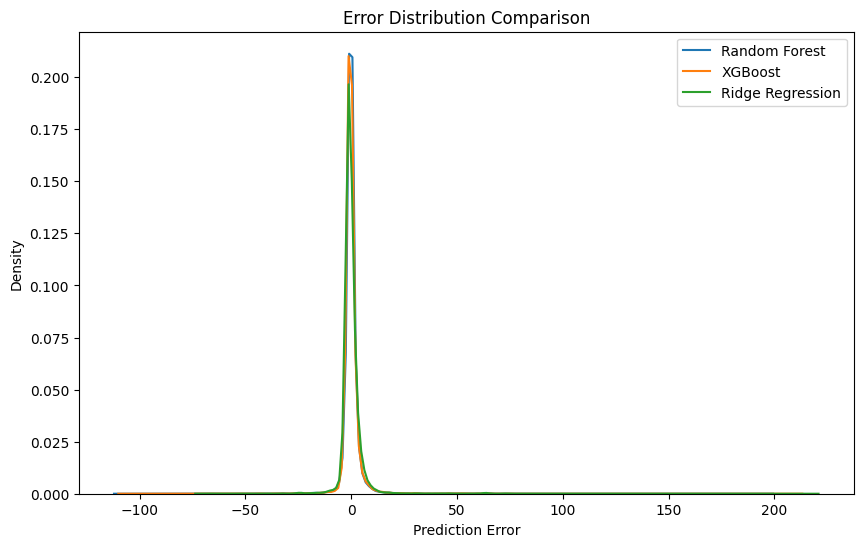

In [50]:
# 3. Error Distribution
plt.figure(figsize=(10, 6))
for name, res in results.items():
    errors = y_test - res['predictions']
    sns.kdeplot(errors, label=name)
plt.title('Error Distribution Comparison')
plt.xlabel('Prediction Error')
plt.legend()
plt.show()

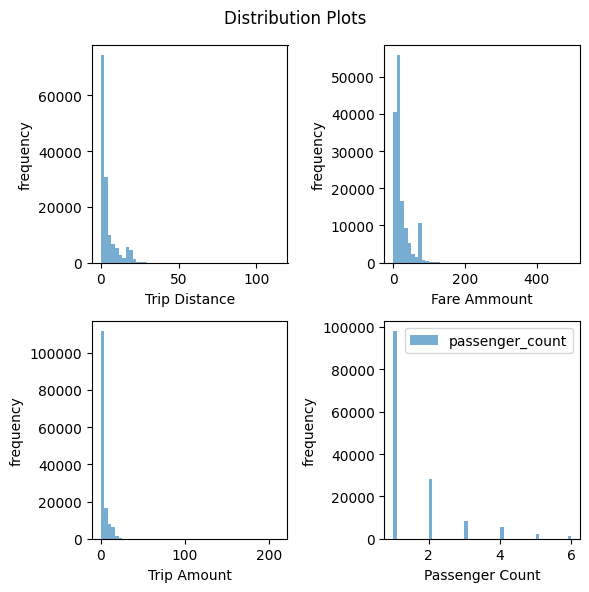

In [151]:
columns_to_plot = ['trip_distance', 'fare_amount', 'tip_amount','passenger_count']
names = ["Trip Distance","Fare Ammount", "Trip Amount","Passenger Count"]
fig,ax =  plt.subplots(2,2,figsize=(6,6))
axs = ax.flatten()
for i,col in enumerate(columns_to_plot):
    axs[i].hist(df[col].compute(), bins=50, alpha=0.6, label=col)
    axs[i].set_xlabel(names[i])
    axs[i].set_ylabel("frequency")

plt.suptitle('Distribution Plots')
plt.legend()
plt.tight_layout()


Reading data from gold_hourly_trips collection...
Loaded 24 rows from gold_hourly_trips into Dask DataFrame


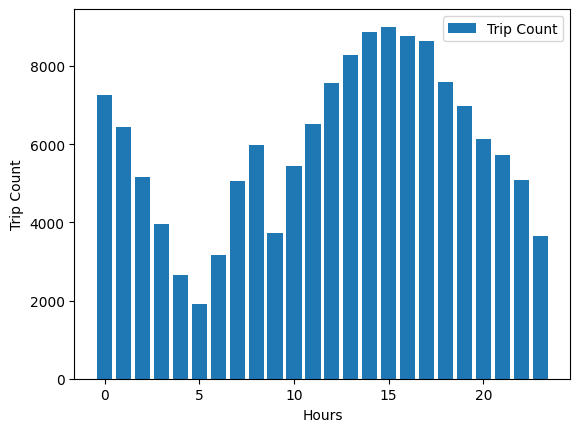

In [153]:
daily_trips = read_data_from_cassandra(database,"gold_hourly_trips")

plt.bar(daily_trips['tpep_pickup_hour'].compute(), daily_trips['trip_count'].compute(),label="Trip Count")
plt.legend()
plt.xlabel("Hours")
plt.ylabel("Trip Count")
plt.show() 

In [159]:
correlation_matrix.compute()

,_id,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,improvement_surcharge,congestion_surcharge,airport_fee,columns
0,b71d627a-b71b-4701-9d62-7ab71b0701fc,-0.000634,0.673778,0.613717,0.306537,0.000406,0.444486,0.408872,0.636716,0.011271,-0.489911,1,airport_fee
0,5a5ca5d7-07a2-442c-9ca5-d707a2c42c12,0.018376,-0.345461,-0.356746,-0.061514,0.088012,-0.155972,-0.175799,-0.319895,-0.001617,1.000000,0,congestion_surcharge
0,ec1e9f5a-5a9c-4f52-9e9f-5a5a9cdf5218,0.019604,0.594046,0.594591,0.141738,-0.055743,1.000000,0.449198,0.711013,0.011802,-0.155972,0,tip_amount
0,d9b33e35-bef2-48c5-b33e-35bef218c529,1.000000,0.044931,0.055800,-0.025862,-0.018180,0.019604,0.049259,0.053033,0.003506,0.018376,0,passenger_count
0,eb3f42cf-d485-4b8e-bf42-cfd485db8e82,0.053033,0.945013,0.982356,0.165660,-0.103336,0.711013,0.712385,1.000000,0.015547,-0.319895,0,total_amount
0,6a3e99ac-b49f-4783-be99-acb49f478301,0.055800,0.951917,1.000000,0.100659,-0.108531,0.594591,0.648429,0.982356,0.013190,-0.356746,0,fare_amount
0,9822c769-eb6c-423b-a2c7-69eb6cd23b8d,0.044931,1.000000,0.951917,0.128964,-0.070528,0.594046,0.636583,0.945013,0.013311,-0.345461,0,trip_distance
0,27df3f1e-6339-4f07-9f3f-1e6339ef0792,0.049259,0.636583,0.648429,0.176326,-0.152570,0.449198,1.000000,0.712385,0.010717,-0.175799,0,tolls_amount
0,ec8dff2b-1157-42d0-8dff-2b1157e2d034,0.003506,0.013311,0.013190,0.015279,-0.074436,0.011802,0.010717,0.015547,1.000000,-0.001617,0,improvement_surcharge
0,86729be1-7138-4e77-b29b-e171382e778e,-0.025862,0.128964,0.100659,1.000000,0.022182,0.141738,0.176326,0.165660,0.015279,-0.061514,0,extra



Reading data from gold_corelation_data collection...
Loaded 11 rows from gold_corelation_data into Dask DataFrame


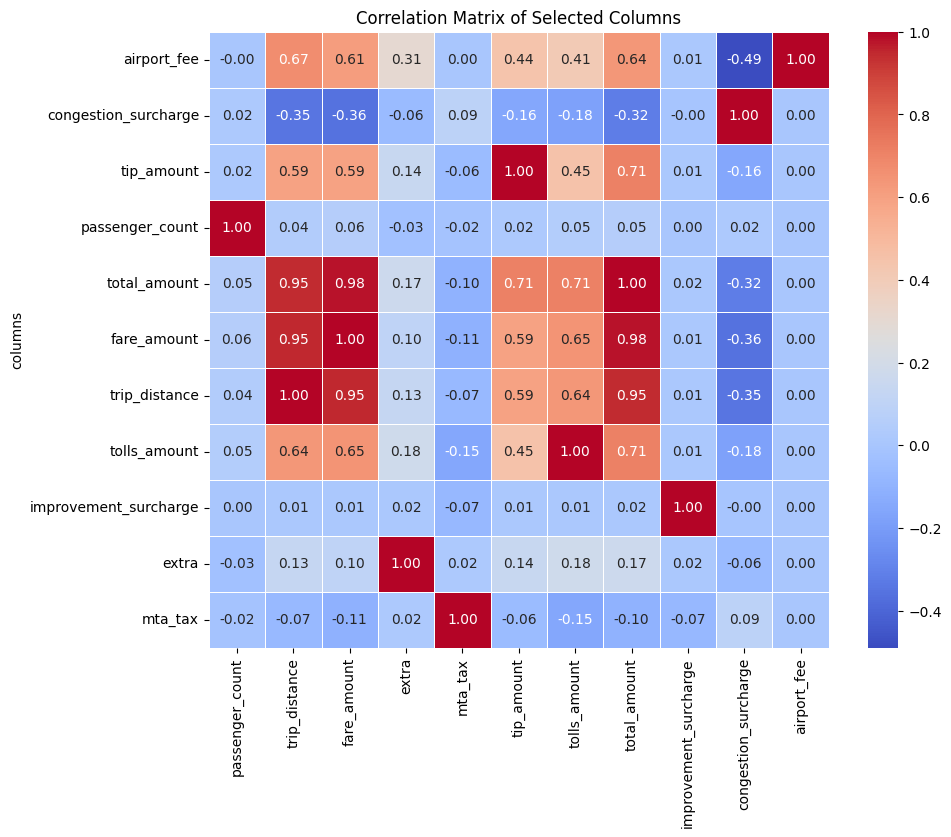

In [160]:
correlation_matrix = read_data_from_cassandra(database,"gold_corelation_data")

correlation_matrix.index = correlation_matrix['columns']
correlation_matrix = correlation_matrix.drop(['_id','columns'], axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.compute(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)

plt.title('Correlation Matrix of Selected Columns')
plt.show()